In [44]:
import pandas as pd 
import matplotlib.pyplot as plt 

import numpy as np 

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from keras.layers import InputLayer, LSTM, Dense, Flatten
from keras.models import Sequential

import tensorflow as tf 
import seaborn as sns


# Get Data from File

In [45]:
dataFileName = "CombinedData.csv"
df = pd.read_csv(dataFileName)
data = df[["datetime", "tempmax", "tempmin", "temp", "feelslikemax", "feelslike", "feelslike", "dew", "humidity", "precip"]]

In [46]:
# Show Dimensions of Data
data.shape

(8514, 10)

# Temperature

Preview Temperature Data first (4) Years of Data

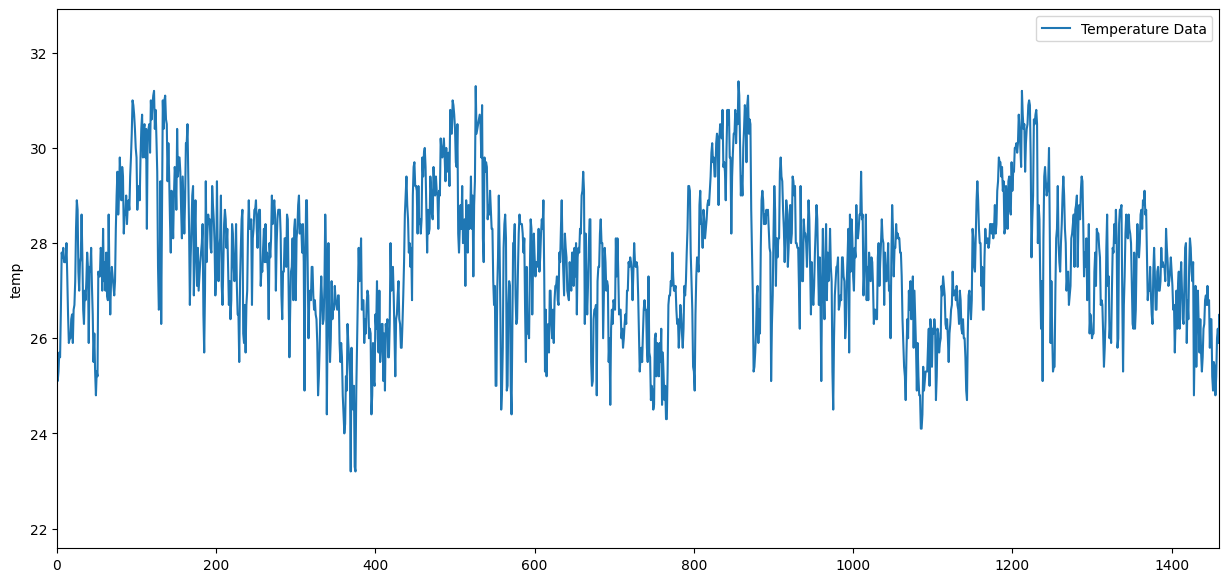

In [25]:
plt.figure(figsize = (15, 7))
plt.xlim(0, 1460)
sns.lineplot(data["temp"], label="Temperature Data")
plt.legend()
plt.show()

In [47]:
# Copy Data to preserve Original Data
temperature_data = data[["datetime", "temp"]].copy()

# Just Rename Data
temperature_data.rename(columns={"datetime" : "Date", "temp" : "Temp"}, inplace = True)
temperature_data["TempMean"] = temperature_data["Temp"]

# Put Month and Year Data based on Date Column
temperature_data["Month"] = pd.DatetimeIndex(temperature_data["Date"]).month 
temperature_data["Year"] = pd.DatetimeIndex(temperature_data["Date"]).year

In [48]:
# Reset Index of Temperature Data
YEAR_LENGTH = 3
# DATASET_LENGTH = YEAR_LENGTH * 365
DATASET_LENGTH = 2000
temperature_data = temperature_data.reset_index()[:DATASET_LENGTH]
temperature_data.head()

,index,Date,Temp,TempMean,Month,Year
0,0,2001-01-01,25.2,25.2,1,2001
1,1,2001-01-02,25.1,25.1,1,2001
2,2,2001-01-03,25.3,25.3,1,2001
3,3,2001-01-04,25.7,25.7,1,2001
4,4,2001-01-05,25.6,25.6,1,2001


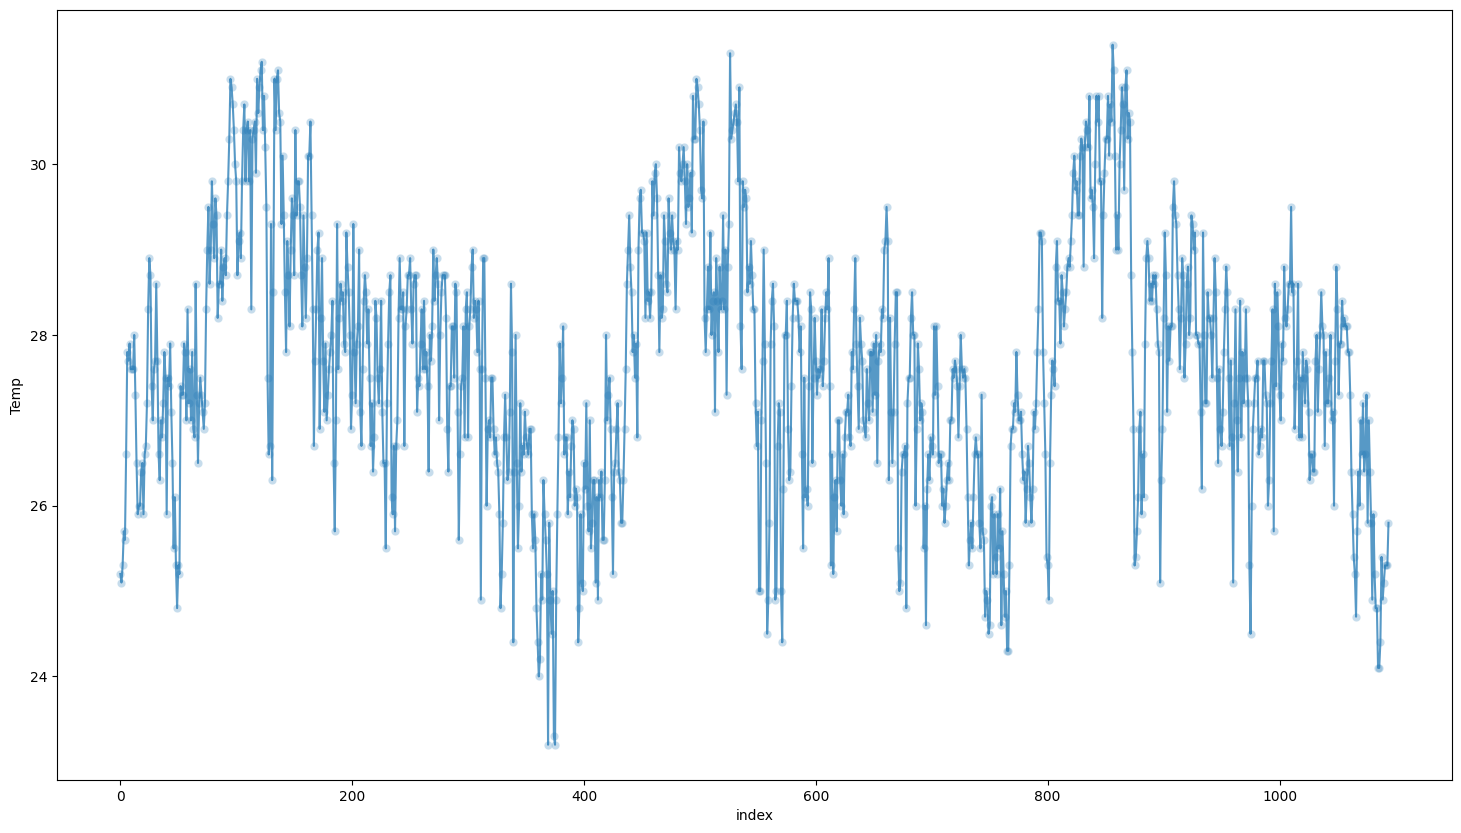

In [41]:
# Display Initial Temeprature Readings
plt.figure(figsize=(18, 10))
sns.scatterplot(data = temperature_data, x = "index", y = "Temp", alpha = 0.25)
sns.lineplot(data = temperature_data, x = "index", y = "Temp", alpha = 0.75)
plt.show()


# Check For Seasonality

Both for Months and For Year

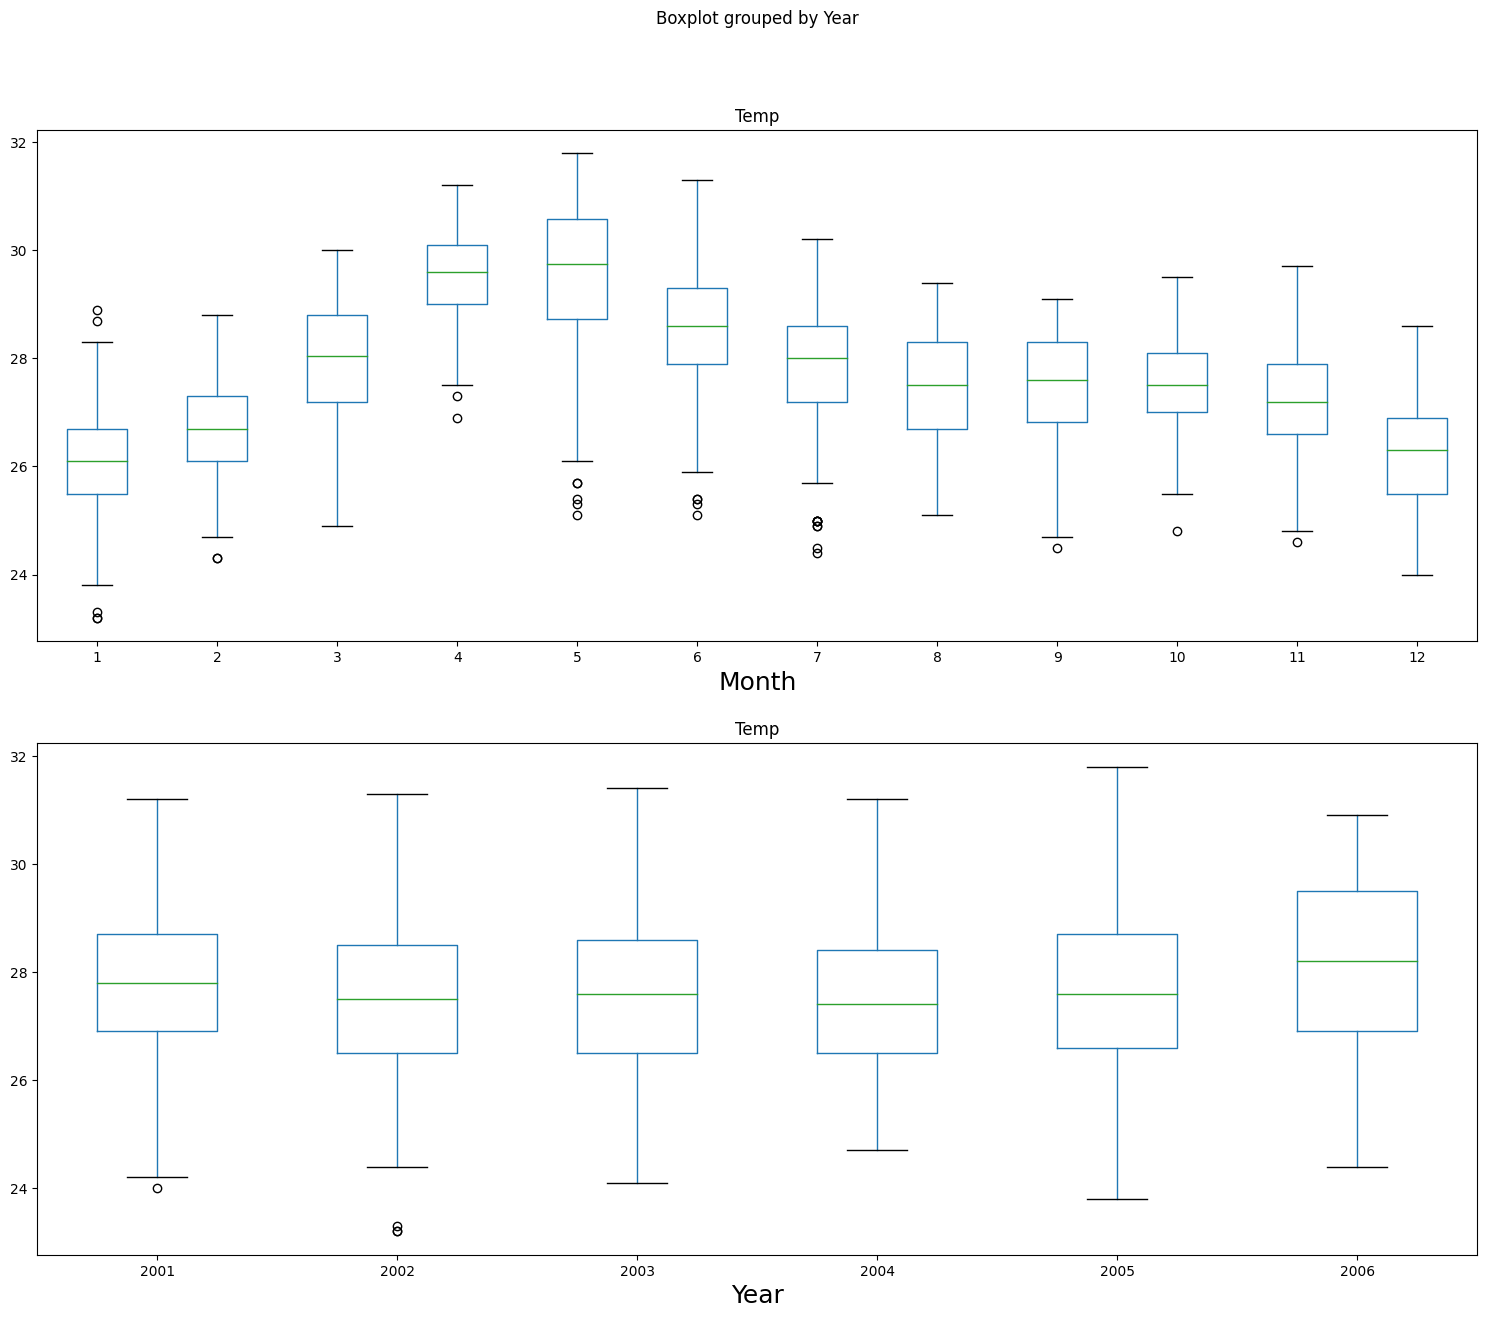

In [49]:
# Seasonality Check for Month

# Pandas Require an Axis therefore, subplots is used
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 15))
temperature_data.boxplot(column = ["Temp"], by = "Month", ax = ax1)
temperature_data.boxplot(column = ["Temp"], by = "Year", ax = ax2)
ax1.grid(False)
ax2.grid(False)
ax1.set_xlabel("Month", fontsize = 18)
ax2.set_xlabel("Year", fontsize = 18)
plt.show()

# Remove Seasonality

From Source, they only subtract therefore only satisfying the numerator for mean numeralization. Standard Deviation would be used later for the prediction and not for the Normalization (Which should be but it is what it is)

Have to Experiment with adding the denominator which would be using the max(x) - min(x) with x as the feature.

Although Adding the Denominator would also mean having to take note of the min, and max per month along with the whole year or just the whole year as it would be needed for inverse transformation

In [50]:
# Get the Monthly Mean (Using the Month Group Made on top)
monthly_mean = temperature_data.groupby(by = "Month").mean(numeric_only = True)["Temp"]

# Adjust the Mean Temperature for such day -> Normalize Per Month (Mean Normalization)
for month in temperature_data["Month"].unique():
    temperature_data.loc[temperature_data["Month"] == month, "TempMean"] -= monthly_mean[month]

# Mean for the whole Normalized Group (Whole Training Set Normalization)
whole_training_set_mean = temperature_data["TempMean"].mean()
temperature_data["TempMean"] -= whole_training_set_mean
print("Whole Training Set Mean:", whole_training_set_mean)

Whole Training Set Mean: 6.394884621840901e-17


# Check Non - Seasonal Transformed Data

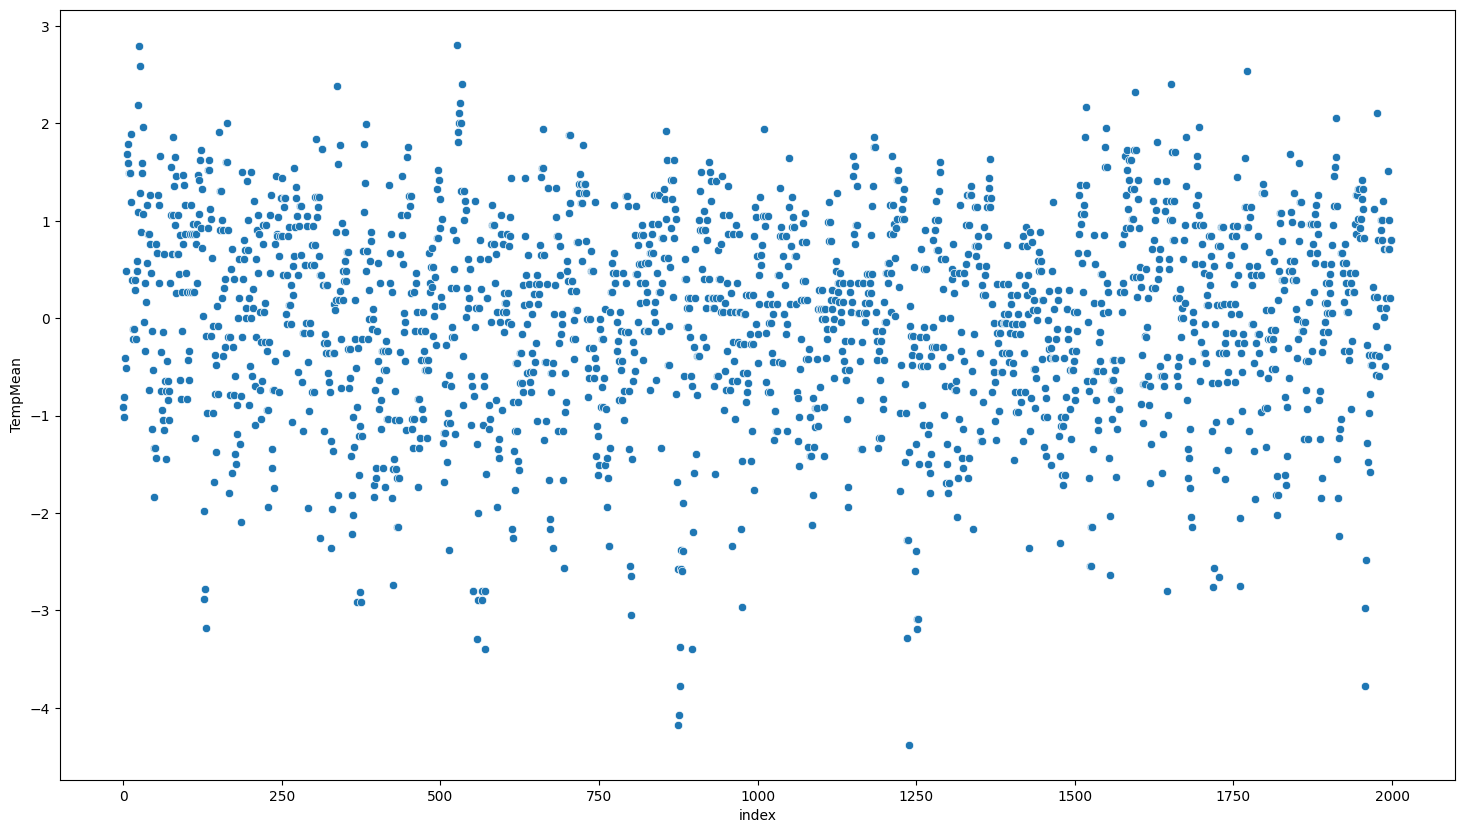

In [51]:
plt.figure(figsize=(18, 10))
sns.scatterplot(data=temperature_data, x='index', y='TempMean')
plt.show()

# Sanity Check (From Source)

To make sure that our data does not have some lag - X correlation

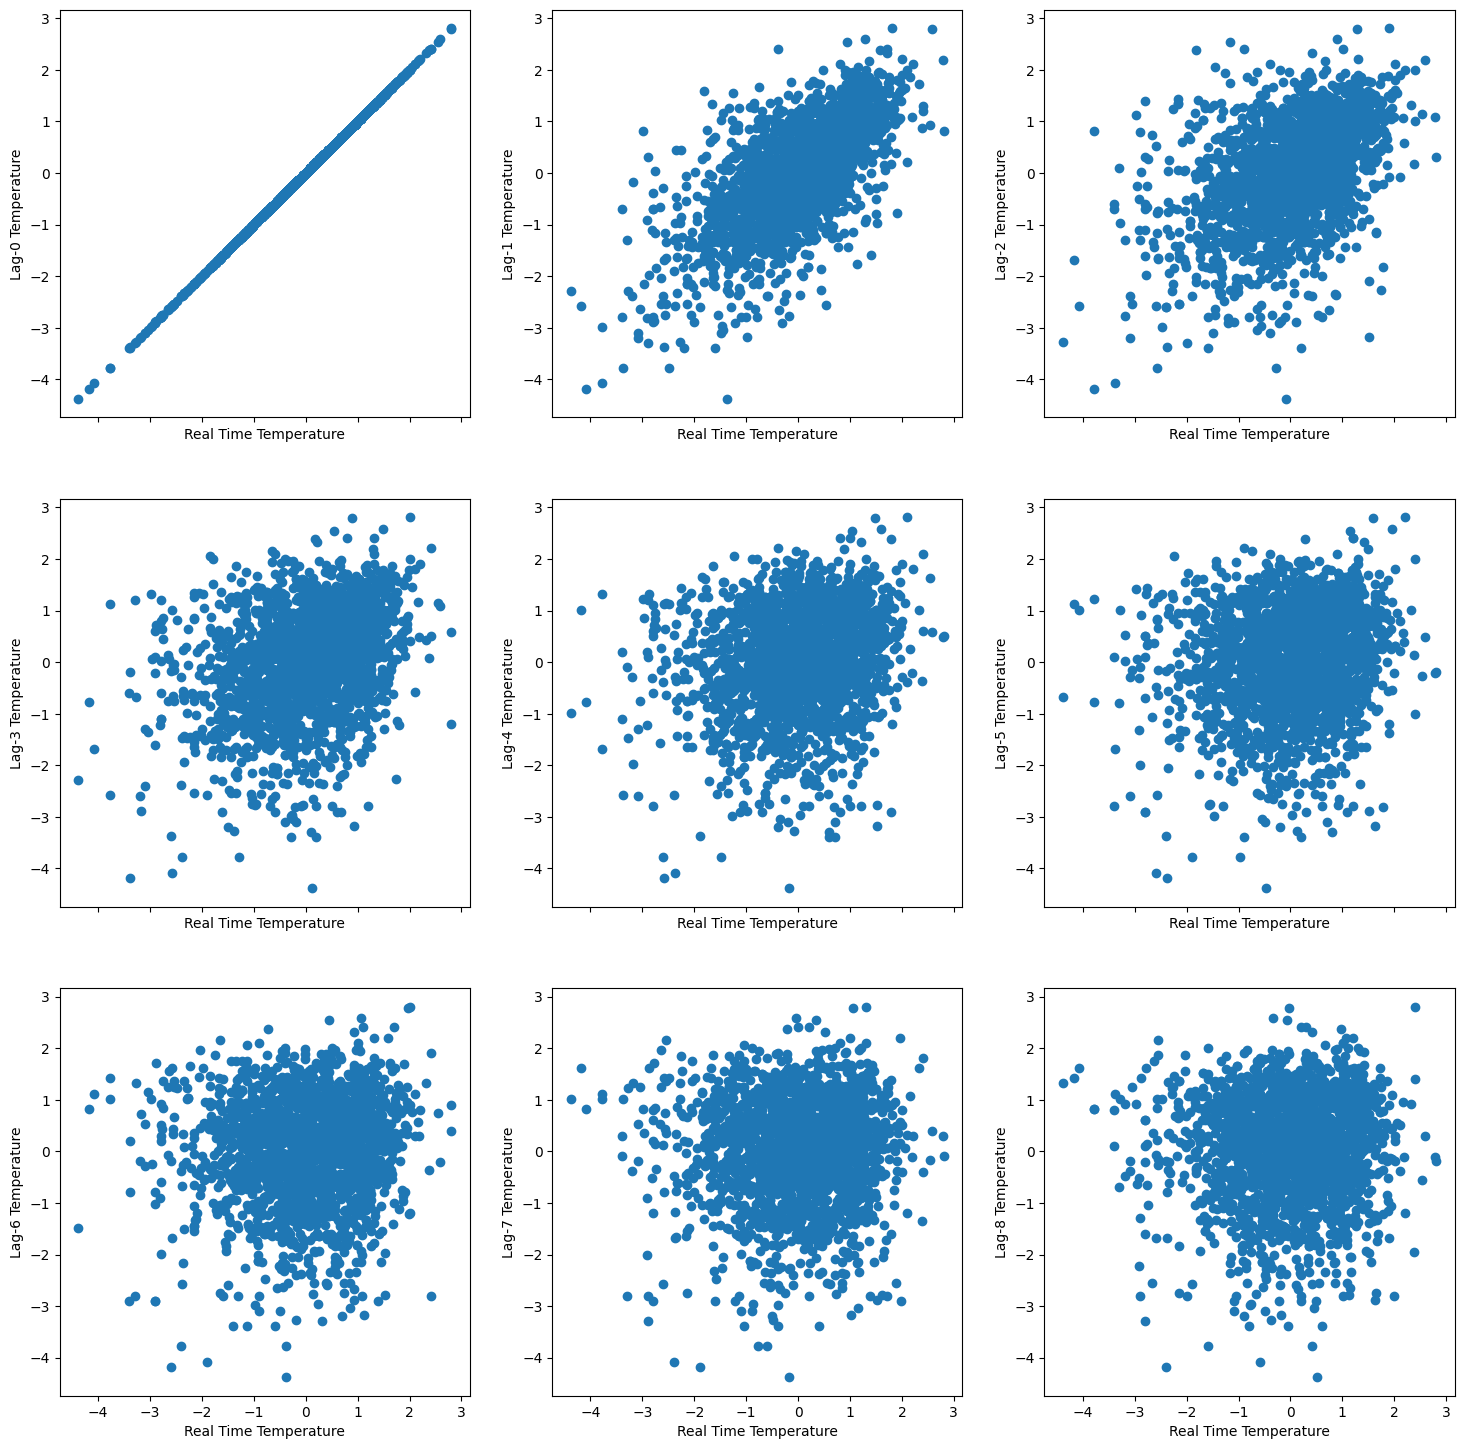

In [68]:
n = 9
current = temperature_data['TempMean'][n:]
fig, axis = plt.subplots(3, n//3, sharex=True, figsize=(18, 18))

for i in range(n):
  if i != 0:
    lag = temperature_data['TempMean'][(n-i):-i]
  else:
    lag = current
  axis[(i)//3, (i)%3].set(xlabel='Real Time Temperature', ylabel=f'Lag-{i} Temperature')
  axis[(i)//3, (i)%3].scatter(current, lag)

# Get Auto Regressive Order 
Using Autocorrelation and Partial Auto Correlation Of Data

The Only Interesting part here would be the Partial Autocorrelation of data where we should look for order at which the point is still outside of the box

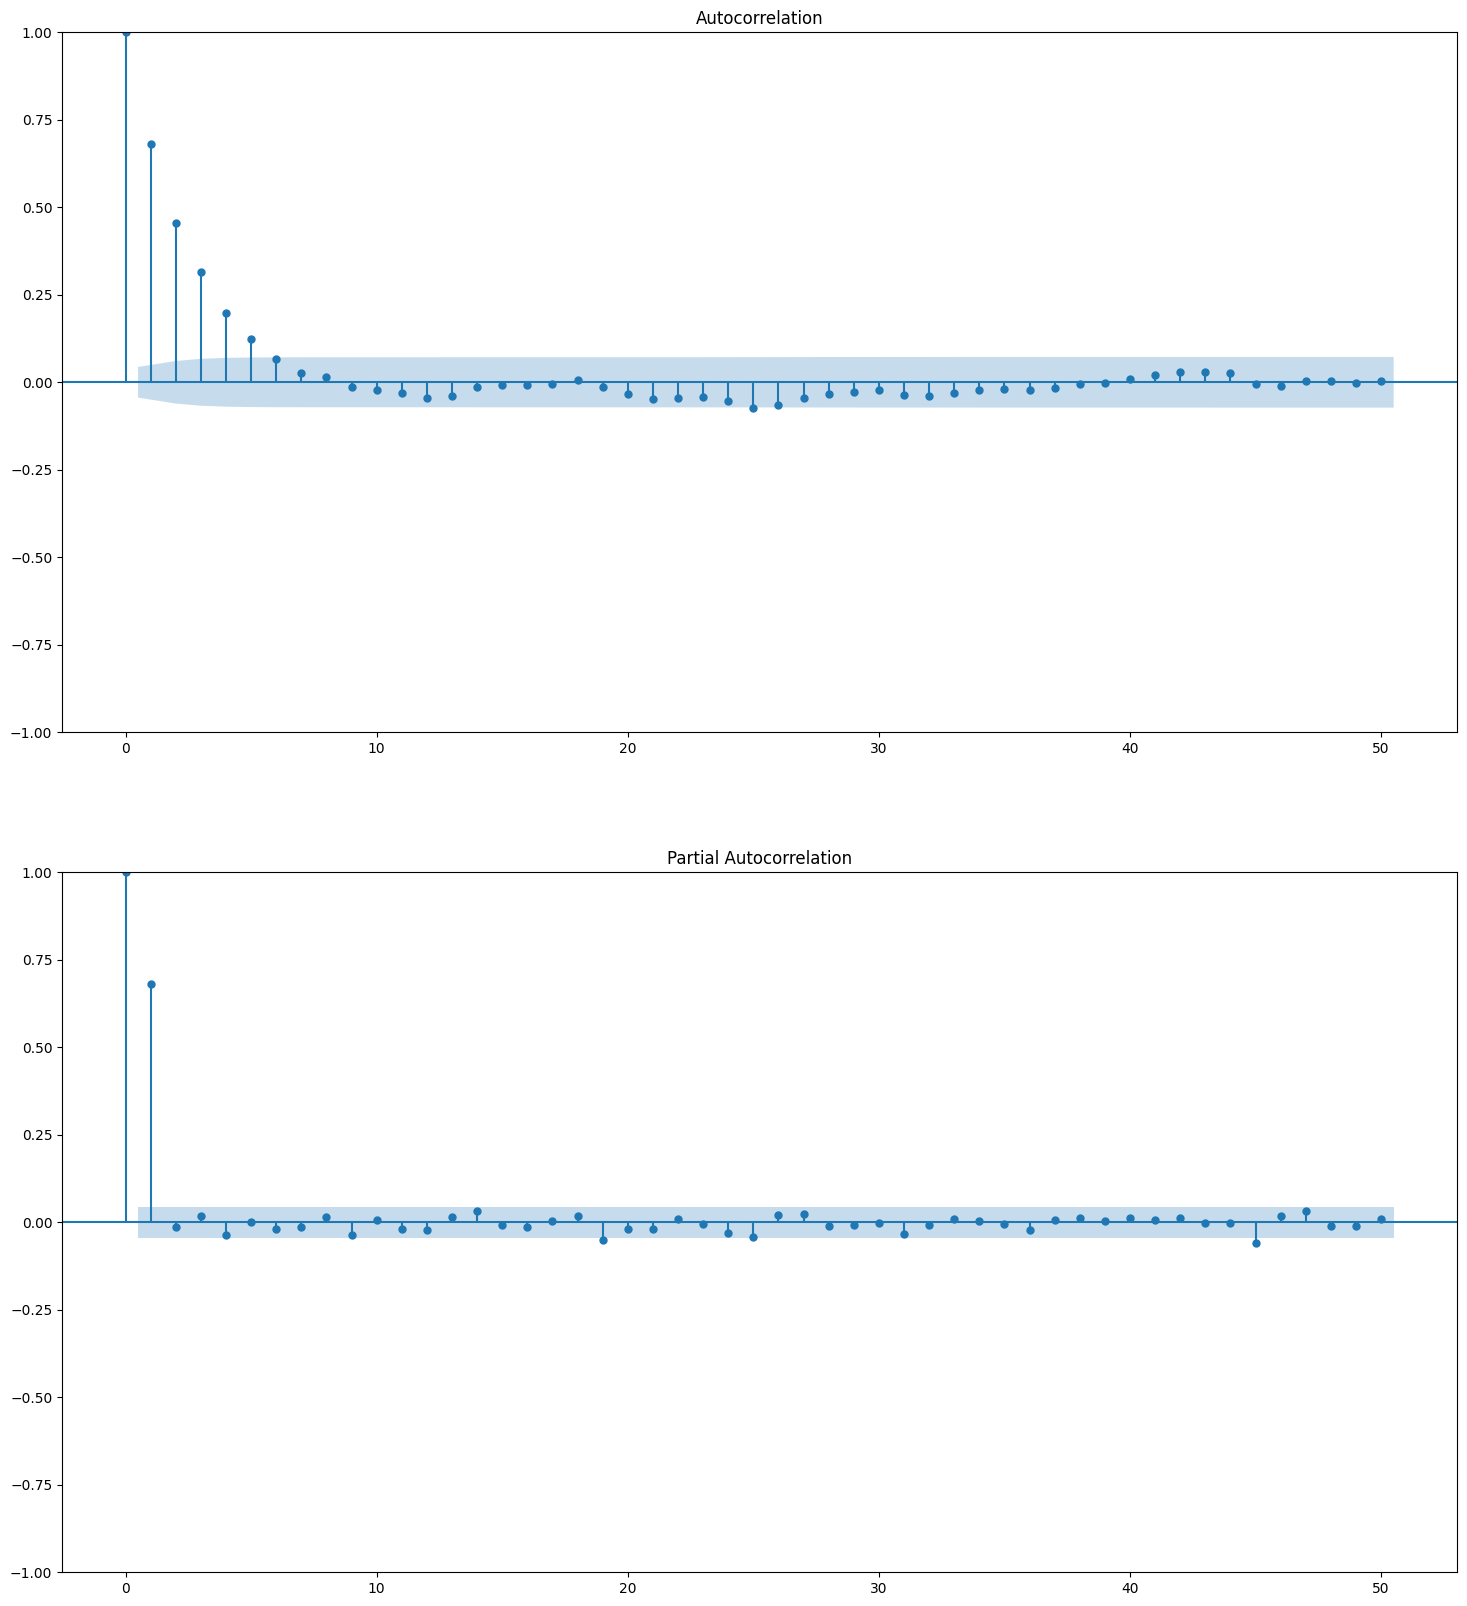

In [69]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axes = plt.subplots(2, 1, figsize=(18, 20), sharey=True)

plot_acf(ax=axes[0], x=temperature_data['TempMean'], lags=50)
plot_pacf(ax=axes[1], x=temperature_data['TempMean'], lags=50)

plt.show()

# Training Proper

In [52]:
# Essentially also Sliding Window Length
Auto_Regressive_Order = 3

# Classifier from SciKit Family
Auto_Regressive_Model = RandomForestRegressor()

# Will be used later for Random Generation of Noise as Input
Model_Noise_Coefficient = None

In [53]:
# Generate Training X, and Y
X = temperature_data["TempMean"].copy().to_numpy()
TRAIN_X = []
TRAIN_Y = []

for i in range(len(X) - Auto_Regressive_Order):
    TRAIN_X.append(X[i : i + Auto_Regressive_Order])
    TRAIN_Y.append(X[i + Auto_Regressive_Order])

TRAIN_X = np.array(TRAIN_X, "float32")
TRAIN_Y = np.array(TRAIN_Y)

In [54]:
# Fit Data on Model
X_Std = np.std(X)
Auto_Regressive_Model.fit(TRAIN_X, TRAIN_Y)

RandomForestRegressor()

In [ ]:
# Check on Training Data

In [55]:
# Build Testing Data
# Copy Data to preserve Original Data
testing_temperature_data = data[["datetime", "temp"]].copy()

# Just Rename Data
testing_temperature_data.rename(columns={"datetime" : "Date", "temp" : "Temp"}, inplace = True)
testing_temperature_data.reset_index()

,index,Date,Temp
0,0,2001-01-01,25.2
1,1,2001-01-02,25.1
2,2,2001-01-03,25.3
3,3,2001-01-04,25.7
4,4,2001-01-05,25.6
...,...,...,...
8509,8509,2024-04-19,30.9
8510,8510,2024-04-20,31.1
8511,8511,2024-04-21,31.2
8512,8512,2024-04-22,31.6


In [74]:
X[0 : Auto_Regressive_Order]

array([-0.91075269, -1.01075269, -0.81075269])

In [75]:
X[Auto_Regressive_Order + 1]

-0.510752688172044

In [71]:
# Check on Testing Data

# MODEL PREDICT
# n = len(testing_temperature_data)
n = len(TRAIN_X)

predictions = []

# 0 -> Auto Regressive Order
sliding_window = X[0 : Auto_Regressive_Order]

for i in tqdm(range(n)):
    prediction_input = sliding_window.reshape(1, -1)
    current_prediction = Auto_Regressive_Model.predict(prediction_input)
    current_prediction += np.random.normal(loc = 0, scale = X_Std)
    # current_prediction += X_Std

    predictions.append(current_prediction)
    sliding_window = np.roll(sliding_window, -1)
    sliding_window[-1] = current_prediction


  0%|          | 0/1997 [00:00<?, ?it/s]


ValueError: X has 9 features, but RandomForestRegressor is expecting 3 features as input.

In [76]:
TRAIN_X.shape

(1997, 3)

In [68]:
fixed_predictions = np.array(predictions).reshape(-1, )
fixed_predictions.shape

(1997,)

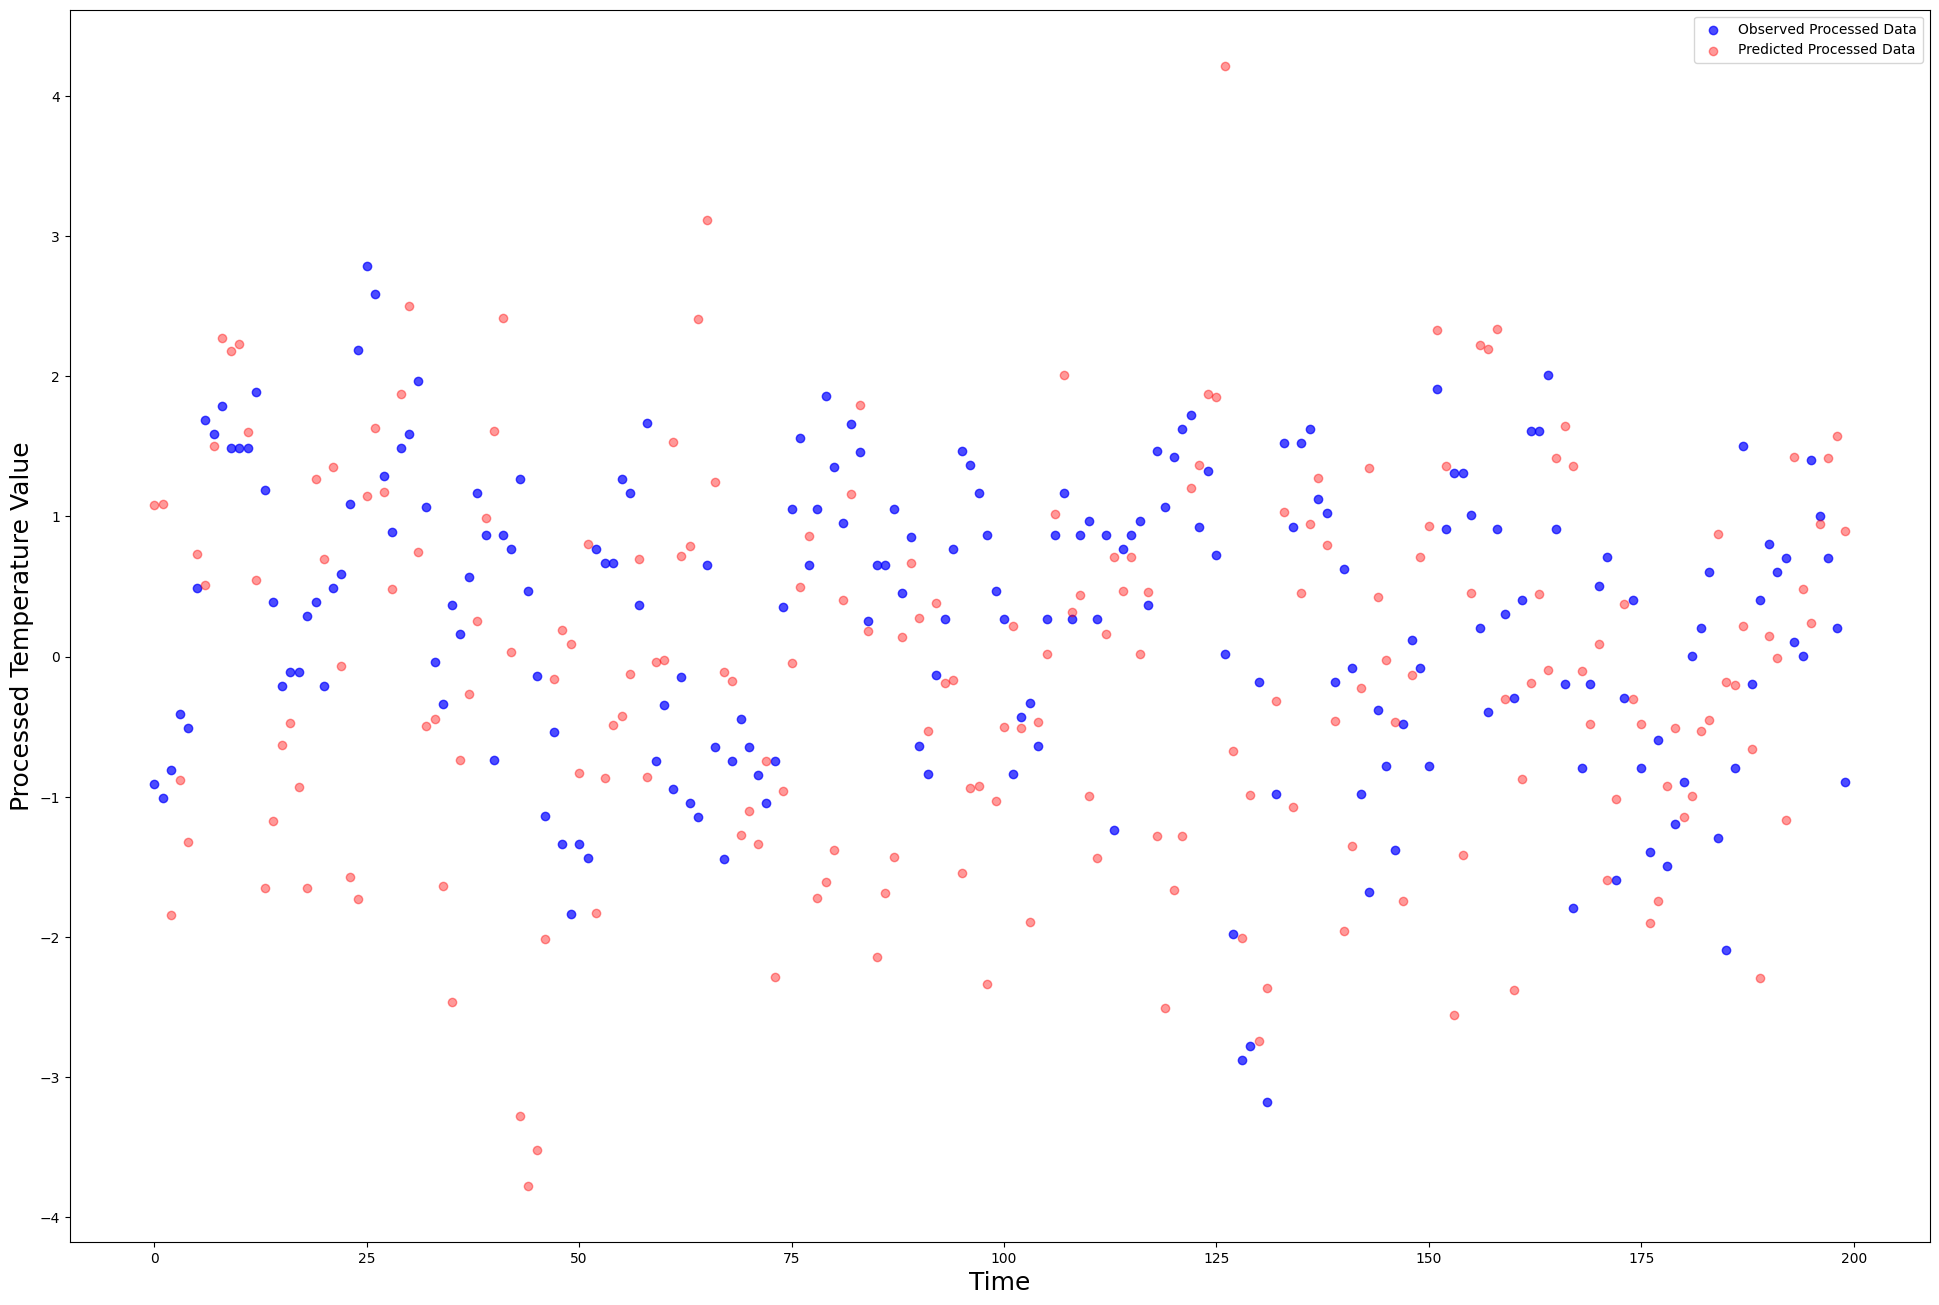

In [69]:
range_check = 200
# real_data = testing_temperature_data["Temp"].to_numpy()[:range_check]
real_data = X[:range_check]
pred_data = fixed_predictions[:range_check]

plt.figure(figsize=(24, 16))
plt.scatter(x=np.arange(range_check), y=real_data, color='blue', alpha=0.7)
plt.scatter(x=np.arange(range_check), y=pred_data, color='red', alpha=0.4)
plt.legend(loc='upper right', labels=['Observed Processed Data', 'Predicted Processed Data'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Processed Temperature Value', fontsize=18)
plt.show()

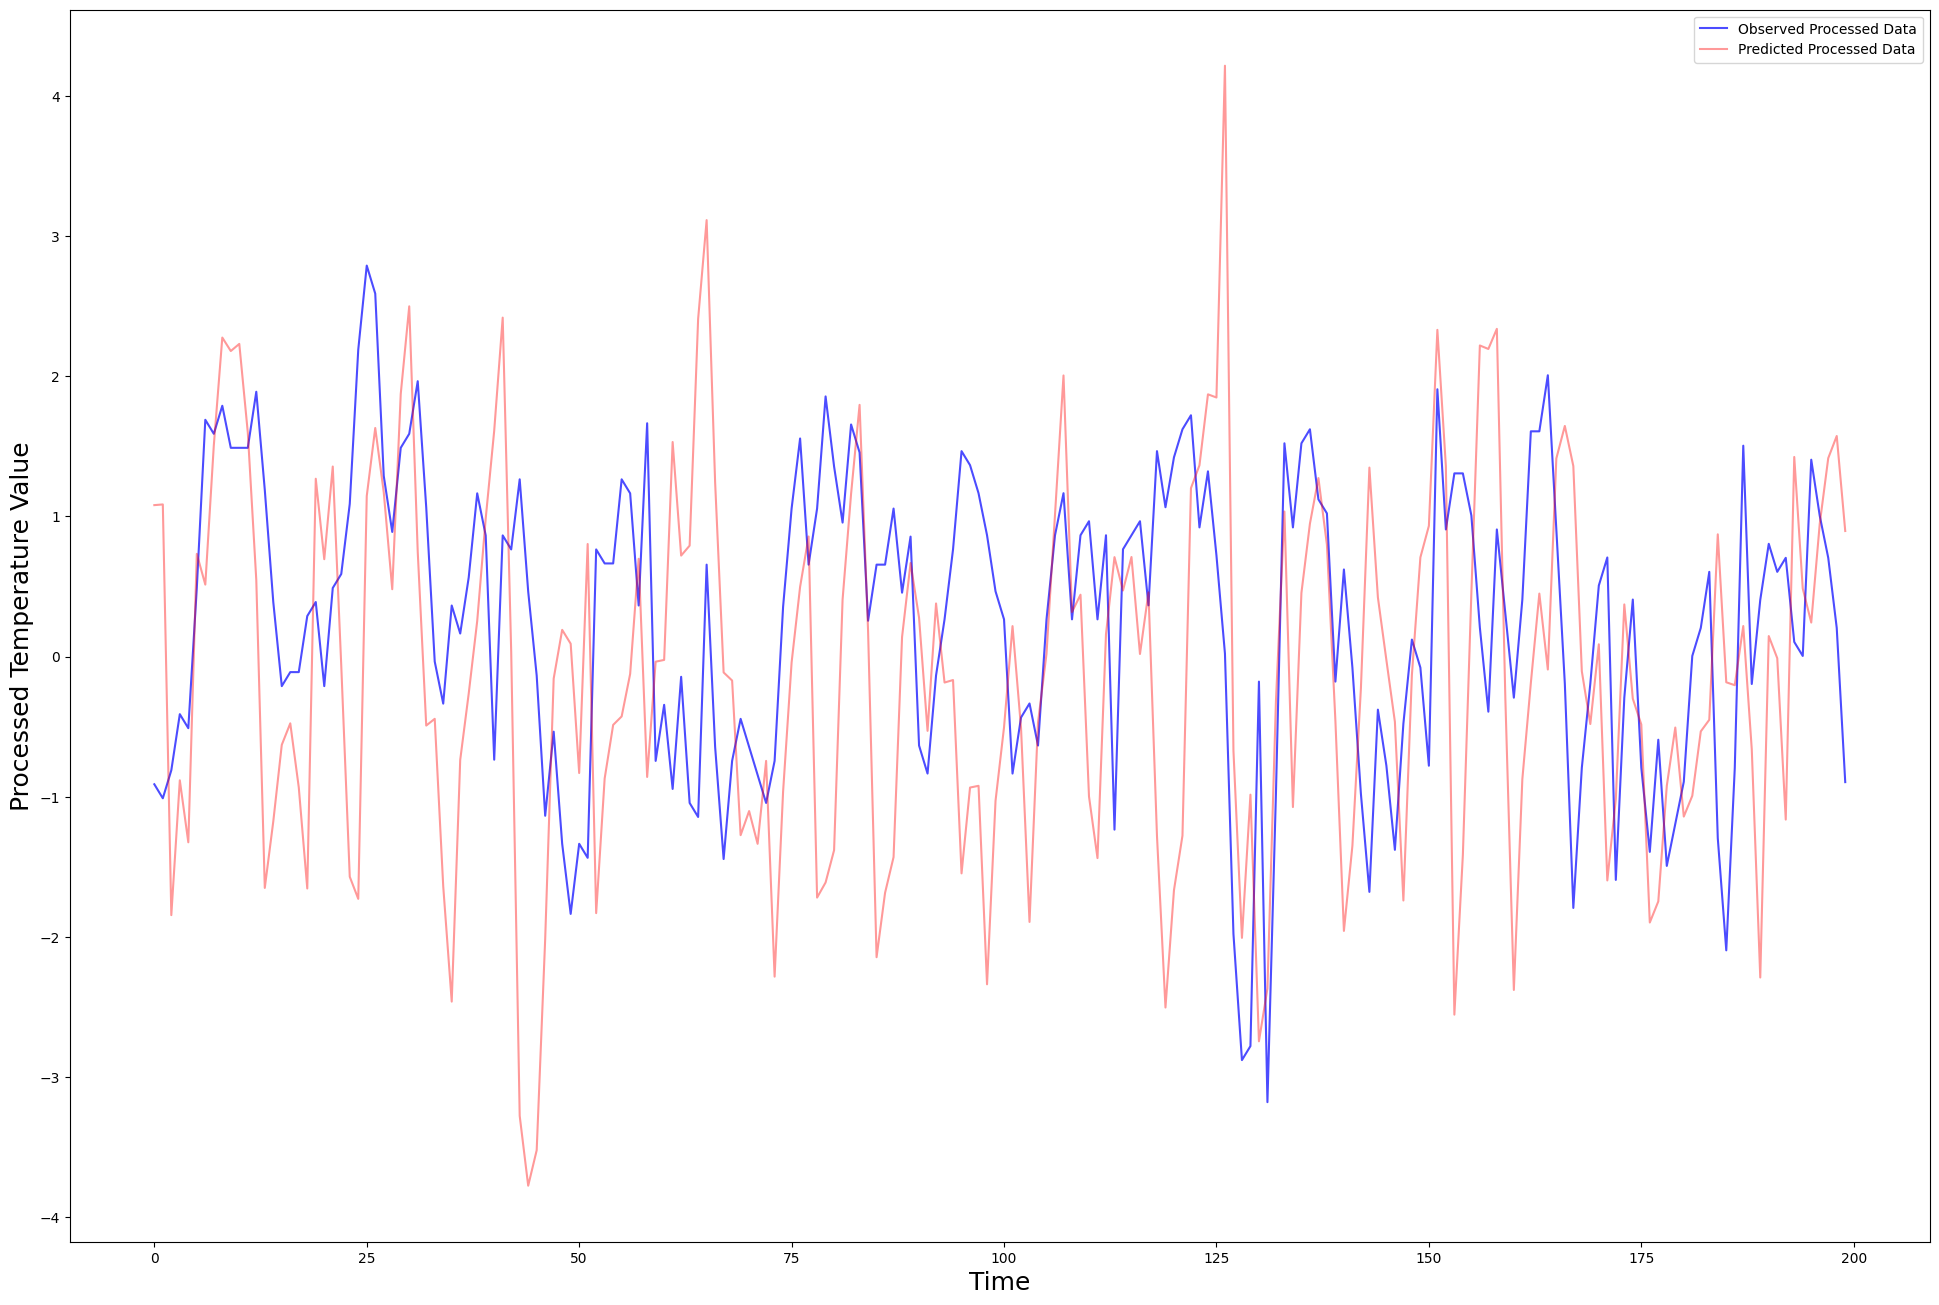

In [70]:
plt.figure(figsize=(24, 16))
plt.plot(real_data, color='blue', alpha=0.7)
plt.plot(pred_data, color='red', alpha=0.4)
plt.legend(loc='upper right', labels=['Observed Processed Data', 'Predicted Processed Data'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Processed Temperature Value', fontsize=18)
plt.show()

In [ ]:
# Evaluate Models (Base)

In [ ]:
# Use Ensemble Model

In [ ]:
# Evaluate Ensemble on Training Set

In [ ]:
# Evaluate Ensemble on Testing Set

In [ ]:
# Analysis on Means per Month and per Year (until 2010)

In [ ]:
# Analysis on Means per Month and per Year (until 2020)

In [ ]:
# Analysis on Means per Month and per Year (until 2024)

In [ ]:
# Only the first 3 Years as Test
train_data = data["temp"].to_numpy()[:4500].reshape(-1, 1)
TempScaler = MinMaxScaler()
# training_data = TempScaler.fit_transform(train_data)
training_data = train_data
training_data = training_data.flatten()

# Window the Data for the last 30 Days
WINDOW_LENGTH = 30
X = []
y = []

for i in range(len(training_data) - WINDOW_LENGTH):
    X.append(training_data[i : i + WINDOW_LENGTH])
    y.append(training_data[i + WINDOW_LENGTH])

X = np.array(X, "float32")
y = np.array(y)

X.shape, y.shape


((4470, 30), (4470,))

In [ ]:
# Build Model
# RFR = RandomForestRegressor()

PredictorModel = LinearRegression()

# PredictorModel = Sequential([
#     InputLayer((WINDOW_LENGTH, 1)),
#     LSTM(32, return_sequences = True),
#     LSTM(32, return_sequences = True),
#     LSTM(32),
#     Flatten(),
#     Dense(1)
# ])

# num_features = 1
# OUT_STEPS = 1 

# class FeedBack(tf.keras.Model):
#     def __init__(self, units, out_steps):
#         super().__init__()
#         self.out_steps = out_steps
#         self.units = units
#         self.lstm_cell = tf.keras.layers.LSTMCell(units)
#         # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
#         self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
#         self.dense = tf.keras.layers.Dense(num_features)

#     def warmup(self, inputs):
#         # inputs.shape => (batch, time, features)
#         # x.shape => (batch, lstm_units)
#         x, *state = self.lstm_rnn(inputs)

#         # predictions.shape => (batch, features)
#         prediction = self.dense(x)
#         return prediction, state
    
#     def call(self, inputs, training=None):
#         # Use a TensorArray to capture dynamically unrolled outputs.
#         predictions = []
#         # Initialize the LSTM state.
#         prediction, state = self.warmup(inputs)

#         # Insert the first prediction.
#         predictions.append(prediction)

#         # Run the rest of the prediction steps.
#         for n in range(1, self.out_steps):
#             # Use the last prediction as input.
#             x = prediction
#             # Execute one lstm step.
#             x, state = self.lstm_cell(x, states=state,
#                                     training=training)
#             # Convert the lstm output to a prediction.
#             prediction = self.dense(x)
#             # Add the prediction to the output.
#             predictions.append(prediction)

#         # predictions.shape => (time, batch, features)
#         predictions = tf.stack(predictions)
#         # predictions.shape => (batch, time, features)
#         predictions = tf.transpose(predictions, [1, 0, 2])
#         return predictions






# feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
# feedback_model.compile(loss = "mse", optimizer = "adam", metrics = ["mae", "mse"])


In [ ]:
# copyX = X.reshape(X.shape[0], X.shape[1], 1)
# copyX.shape

(4470, 30, 1)

In [ ]:
# Train Model
# RFR.fit(X, y)
PredictorModel.fit(X, y)
# history = feedback_model.fit(copyX, y, epochs=20)
# PredictorModel.compile(loss = "mae", optimizer = "adam", metrics = ["mse"])
# PredictorModel.fit(X, y, validation_split=0.1, epochs=10)

LinearRegression()

In [ ]:
# Build Testing Data
test_data = data["temp"].to_numpy()[4500:8000].reshape(-1, 1)
# testing_data = TempScaler.transform(test_data)
testing_data = test_data
testing_data = testing_data.flatten()

# Window the Data for the last 30 Days
TEST_X = []
TEST_y = []

for i in range(len(testing_data) - WINDOW_LENGTH):
    TEST_X.append(testing_data[i : i + WINDOW_LENGTH])
    TEST_y.append(testing_data[i + WINDOW_LENGTH])

TEST_X = np.array(TEST_X, "float32")
TEST_y = np.array(TEST_y)

TEST_X.shape, TEST_y.shape

((3470, 30), (3470,))

In [ ]:
# feedback_model.predict(TEST_X[1].reshape(1, -1, 1)), TEST_y[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


(array([[[0.5059586]]], dtype=float32), 0.8404255319148941)

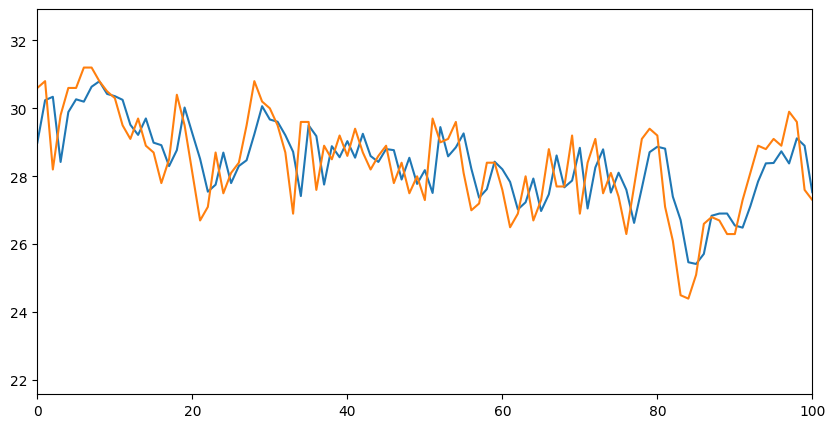

In [ ]:
# Normal Prediction
# RFR_pred_normal = RFR.predict(TEST_X).reshape(-1, 1)
# pred_normal = feedback_model.predict(TEST_X.reshape(TEST_X.shape[0], -1, 1)).reshape(-1, 1)
# pred_normal = PredictorModel.predict(TEST_X).reshape(-1, 1)
pred_normal = PredictorModel.predict(TEST_X)
# pred_normal = TempScaler.inverse_transform(pred_normal).flatten()
# tY = TempScaler.inverse_transform(TEST_y.reshape(-1, 1)).flatten()
ty = TEST_y

plt.figure(figsize=(10, 5))
plt.plot(pred_normal, label = "Normal Prediction (RFR)")
plt.plot(tY, label="Actual Values")
plt.xlim(0, 100)
plt.show()

In [ ]:
TEST_X[0].shape

(30,)

In [ ]:
np.array([TEST_X[0]]).shape

(1, 30)

In [ ]:
# Abnormal Prediction - AutoRegression
current_window = TEST_X[0]
predictions = []
for i in tqdm(range(len(TEST_y))):
    # print(i, current_window.shape, len(predictions))
    # current_prediction = RFR.predict(np.array([current_window]))
    # current_prediction = PredictorModel.predict(np.array([current_window]), verbose = 0)
    current_prediction = PredictorModel.predict(np.array([current_window]))
    predictions.append(current_prediction.flatten())
    current_window = current_window[1:]
    current_window = np.append(current_window, current_prediction)

predictions = np.array(predictions).flatten()

100%|██████████| 3470/3470 [00:00<00:00, 12917.83it/s]


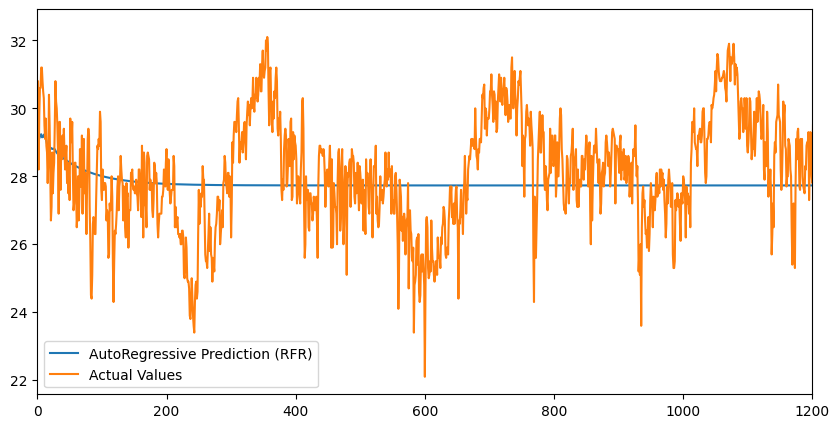

In [ ]:
# RFR_pred_auto = predictions.reshape(-1, 1)
pred_auto = predictions
# RFR_pred_auto = TempScaler.inverse_transform(RFR_pred_auto).flatten()
# autoTY = TempScaler.inverse_transform(TEST_y.reshape(-1, 1)).flatten()
autoTY = TEST_y 

plt.figure(figsize=(10, 5))
plt.plot(pred_auto, label = "AutoRegressive Prediction (RFR)")
plt.plot(autoTY, label="Actual Values")
plt.xlim(0, 1200)
plt.legend()
plt.show()

In [ ]:
# Compare with Real